# Backup Coverage Location Set Covering Problem (LSCP-B)

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

The Backup coverage problem is refered to as an extension of the LSCP (location set covering problem) as it seeks a solution to LSCP while selecting a set of facilities that optimizes for backup coverage (Church L., Murray, A. (2018)). If you are unfamiliar with LSCP the following [notebook](https://pysal.org/spopt/notebooks/lscp.html) explains the problem formulation in detail.

Daskin and Stern (1981) posed the following problem which Church L., Murray, A. (2018) refers to as LSCP-B (location set covering problem with backup):

_Find the minimum number of facilities and their locations such that each demand is covered, while maximizing the number of backup coverage instances among demand areas._ Church L., Murray, A. (2018)

**LSCP-B can be written as:**

\begin{equation*}
\textbf{Maximize }\sum_{i} U_i
\end{equation*}

_Subject to:_
\begin{equation*}
\sum_{j} a_{ij}X_j \geq 1 + U_i \quad \forall i
\end{equation*}

\begin{equation*}
\sum_j X_j = p
\end{equation*}

\begin{equation*}
X_j = \{0, 1\} \quad \forall j
\end{equation*}

\begin{equation*}
U_i \leq 1 \quad \forall i
\end{equation*}

_Where:_

\begin{array}{lcllll}
& & j & \small = & \textrm{index of potential facility sites where} \quad j = 1, 2, . . . ,m \\
& & i & \small = & \textrm{index of demand units where} \quad i = 1, 2, . . . ,n \\
& & p & \small = & \textrm{objective value identified by using the LSCP} \\
& & U_i & \small = & \begin{cases} 
          1, \quad \text{If a demand unit is covered twice} \\
          0, \quad \text{if a demand unit is covered once} \end{cases} \\
& & a_{ij} & \small = & \begin{cases} 
          1, \quad \text{if facility located at site} \quad j \quad \text{covers demand unit} \quad i \\
          0, \quad \text{if not} \end{cases} \\

& & X_j & \small = & \begin{cases} 
          1, \quad \text{if a facility is located at potential site} \quad j \\
          0, \quad \text{otherwise} \\
       \end{cases} \end{array}




_See Church L., Murray, A. (2008)_


This tutorial solves for both LSCP and LSCP-B using `spopt.locate.coverage.LSCP` and `spopt.locate.coverage.LSCPB` instances that depend on a 2D array representing the costs between facilities candidate sites and demand points. Costs are calculated from a 10x10 lattice with simulated points.

In [1]:
from spopt.locate.coverage import LSCP, LSCPB
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


Since the model needs a distance cost matrix we start with defining our variables. In the comments, it's defined what these variables are for except for solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [2]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 5 # quantity supply points

SERVICE_RADIUS = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5 
FACILITY_SEED = 6 

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

## Lattice 10x10

Create a 10x10 lattice with 9 vertical lines in interior.

In [3]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform spaghetti instance into geodataframe.

In [4]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

Plotting the network created by spaghetti we can verify the simulation of a district with quarters and streets.

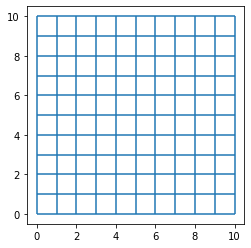

In [5]:
street.plot()

## Simulate points in a network

The function `simulated_geo_points` simulates points inside a network. In this case, it uses a lattice network 10x10 created using the spaghetti package. 
Below we use the function defined above and simulate the points inside the lattice bounds.

In [6]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client and 5 facility points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created on previous cells.

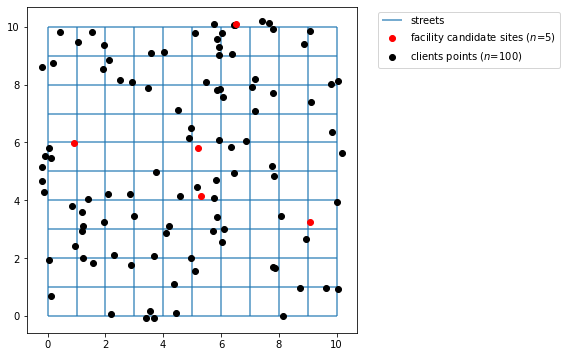

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Transform simulated points to real points

To use a cost matrix or geodataframes we have to pay attention to certain details. The client and facility points simulated don't currently belong to a network, so if we calculate the network distances now we would receive an incorrect result. Before calculating distances we must snap points to the network and then calculate the distances.

Below we snap points to the lattice created above and create new real points geodataframes.

In [8]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)


The plot is now visually more organized as the points belong to a network. 
The network created is plotted below with facility points and clients points:

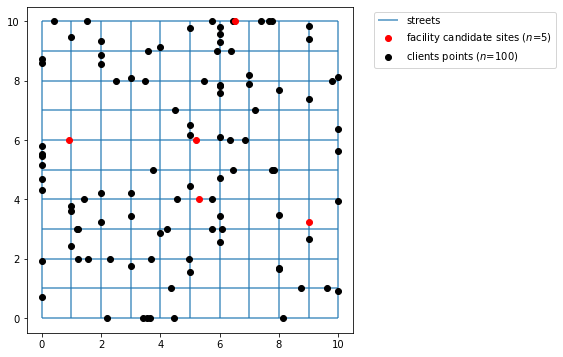

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=100)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

## Calculating the cost matrix 

Calculate distance between clients and facilities.

In [10]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result is a Dijkstra distance between clients and facilities points, so we our case an array 2D 100x5.

In [11]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655,  6.04319467,  5.65607701],
       [13.10096347,  4.43392397,  8.66365401,  6.54113213,  5.15813955],
       [ 6.9095462 ,  4.2425067 ,  2.47223674,  0.34971486,  5.34955682],
       [ 2.98196832,  7.84581224,  3.45534114,  3.57786302,  6.25374871],
       [ 7.5002892 ,  6.32806975,  4.55779979,  6.43527791, 11.75939222],
       [ 0.60209077, 11.42987132,  5.03940023,  7.16192211,  9.8378078 ],
       [ 5.37335867,  6.20113923,  2.43086927,  4.30834738,  9.6324617 ],
       [ 5.40801577,  5.41976478,  3.02929369,  1.15181557,  4.85108725],
       [ 3.68807115,  8.51585171,  2.12538061,  4.24790249,  7.94717417],
       [14.22503627,  4.60274429,  9.78772681,  7.66520493,  4.98931924],
       [10.32521229,  4.99225179,  7.38272288,  9.260201  , 14.58431531],
       [ 6.65436171,  7.98732222,  5.59685112,  3.719373  ,  2.58135531],
       [11.55510375,  1.11193575,  7.11779429,  5.37988496, 10.70399927],
       [10.90832519,  1.75871431,  6.4

We will solve for both LSCP and LSCP-B and plot and compare the results to demonstrate their similarities and differences. 

With ``LSCP.from_cost_matrix`` we model the LSC problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using the cost matrix calculated previously.

With ``LSCPB.from_cost_matrix`` we model the LSC Backup problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using the cost matrix calculated previously.

In [12]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, SERVICE_RADIUS)
lscp_from_cost_matrix = lscp_from_cost_matrix.solve(solver)

lscpb_from_cost_matrix = LSCPB.from_cost_matrix(cost_matrix, SERVICE_RADIUS, solver)
lscpb_from_cost_matrix = lscpb_from_cost_matrix.solve(solver)

Expected result is an instance of LSCP and LSCPB.

In [13]:
lscp_from_cost_matrix

In [14]:
lscpb_from_cost_matrix

## Using a GeoDataFrame

Assign a predefined location using a geodataframe column

In [15]:
facilities_snapped['predefined_loc'] = numpy.array([0, 0, 0, 0, 1])
facilities_snapped

,id,geometry,comp_label,predefined_loc
0,0,POINT (9.00000 3.25259),0,0
1,1,POINT (0.91963 6.00000),0,0
2,2,POINT (5.31010 4.00000),0,0
3,3,POINT (5.18758 6.00000),0,0
4,4,POINT (6.51169 10.00000),0,1


With ``LSCP.from_geodataframe`` we model the LSC problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using geodataframes without calculating the cost matrix previously.

With ``LSCPB.from_geodataframe`` we model the LSC Backup problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using geodataframes without calculating the cost matrix previously.

In [16]:
lscp_from_geodataframe = LSCP.from_geodataframe(
    clients_snapped, facilities_snapped, "geometry", "geometry", 7, distance_metric="euclidean"
)
lscp_from_geodataframe = lscp_from_geodataframe.solve(solver)

In [17]:
lscpb_from_geodataframe = LSCPB.from_geodataframe(
    clients_snapped, facilities_snapped, "geometry", "geometry", 7, solver, distance_metric="euclidean"
)
lscpb_from_geodataframe = lscpb_from_geodataframe.solve(solver)

Expected result is an instance of LSCP and LSCPB

In [18]:
lscp_from_geodataframe

In [19]:
lscpb_from_geodataframe

Modelling LSCP and LSCPB with preselected facilities

In [20]:
lscp_preselected_from_geodataframe = LSCP.from_geodataframe(
    clients_snapped, facilities_snapped, "geometry", "geometry", SERVICE_RADIUS, predefined_facility_col="predefined_loc", distance_metric="euclidean"
)
lscp_preselected_from_geodataframe = lscp_preselected_from_geodataframe.solve(solver)

In [21]:
lscpb_preselected_from_geodataframe = LSCPB.from_geodataframe(
    clients_snapped, facilities_snapped, "geometry", "geometry", SERVICE_RADIUS, solver, predefined_facility_col="predefined_loc", distance_metric="euclidean"
)
lscpb_preselected_from_geodataframe = lscpb_preselected_from_geodataframe.solve(solver)

## Plotting the results

The cell below describes the plotting of the model results. For each method executed for the LSCP and LSCPB classes (from_cost_matrix, from_geodataframe) there is a corresponding plot. Selected facility sites (stars) are assigned a unique color, demand points covered by a facility are assigned the facility's unique color scheme. Demand points with multiple color rings represents facility coverage overlapping. Small red stars represent candidate facility sites that were not chosen.

In [22]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar

dv_colors = [
    "saddlebrown",
    "darkgoldenrod",
    "mediumseagreen",
    "lightskyblue",
    "lavender",
    "darkslategray",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "cyan",
    "limegreen",
    "peachpuff",
    "blueviolet",
    "fuchsia",
    "thistle",
]

def plot_results(model, facility_points_gdf, demand_points_gdf, facility_count, title, p):
    
    arr_points = [] 
    fac_sites = [] 
    
    for i in range(facility_count):
        if model.fac2cli[i]:
            geom = demand_points_gdf.iloc[model.fac2cli[i]]["geometry"]
            arr_points.append(geom)
            fac_sites.append(i)

    
    fig, ax = plt.subplots(figsize=(10, 15))
    legend_elements = []

    street.plot(ax=ax, alpha=1, color='black', zorder=1)
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color='black',
        label='streets',
    ))
    
    demand_points_gdf.plot(
        ax=ax, fc="k", ec="k", marker="s", markersize=7, zorder=2, lw=.5
    )

    facility_points_gdf.plot(
        ax=ax, fc="brown", marker="*", markersize=80, zorder=8
    )
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            marker="*",
            markerfacecolor="brown",
            markeredgecolor="brown",
            markeredgewidth=.5, 
            ms=20,
            lw=0,
            label=f"Unselected Candidate Store sites ($n$={facility_count})"
        )
    )

    _zo, _ms = 4, 4
    
    for i in range(len(arr_points)):

        cset = dv_colors[i]
        fac = fac_sites[i] 
        fname = fac_sites[i]
        fname = f"Facility y{fname}" 
        
        gdf = geopandas.GeoDataFrame(arr_points[i])
        
        label = f"Demand sites covered by {fname}"
        gdf.plot(ax=ax, zorder=_zo, ec="k", fc=cset, markersize=100*_ms, lw=.5,) 
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="o",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=.5, 
                ms= _ms + 7,
                lw=0,
                label=label
            )
        )
        
        facility_points_gdf.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec="k", lw=.5
        )
        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                marker="*",
                markerfacecolor=cset,
                markeredgecolor="k",
                markeredgewidth=.5,
                ms=20,
                lw=0,
                label=fname,
            )
        )
        
        _zo += 1
        _ms -= (1)*(4/p)
     
    plt.title(title, fontsize=20)
    kws = dict(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=15) 
    plt.legend(handles=legend_elements, **kws)

### LSCP and LSCPB built from cost matrix

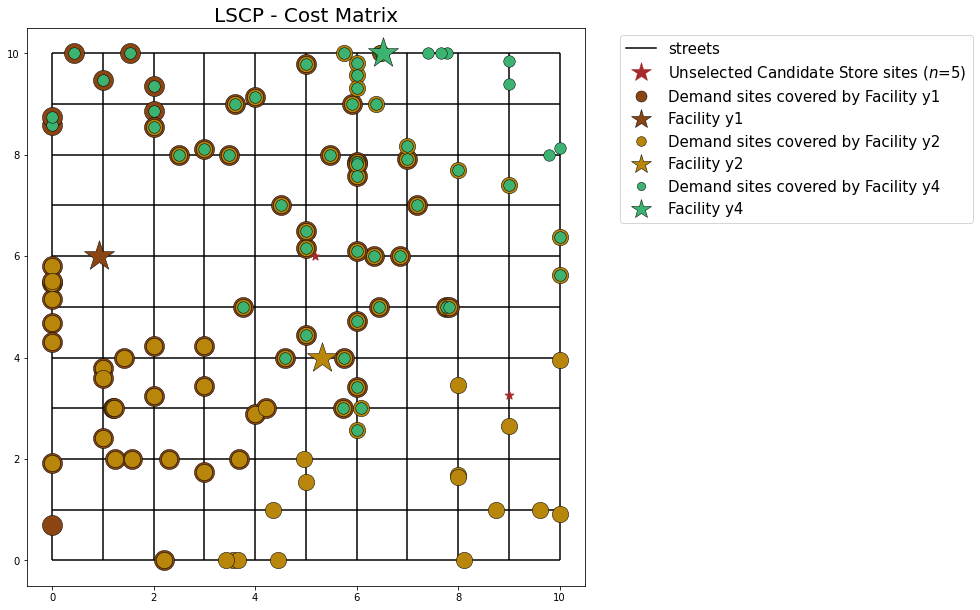

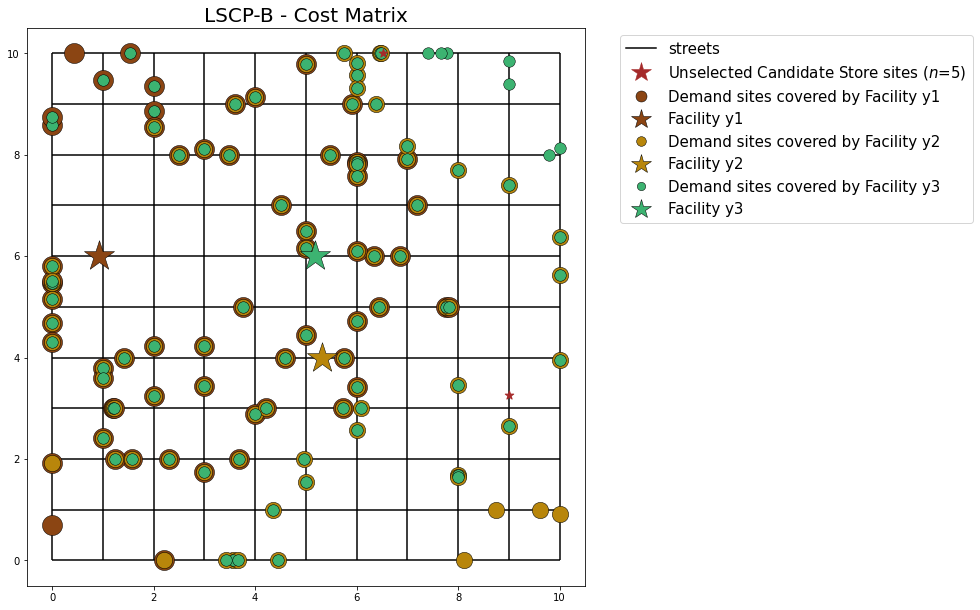

In [23]:
plot_results(lscp_from_cost_matrix, facilities_snapped, clients_snapped, facilities_snapped.shape[0], "LSCP - Cost Matrix", lscp_from_cost_matrix.problem.objective.value())
plot_results(lscpb_from_cost_matrix, facilities_snapped, clients_snapped, facilities_snapped.shape[0], "LSCP-B - Cost Matrix", lscpb_from_cost_matrix.lscp_obj_value)

### LSCP built from geodataframe

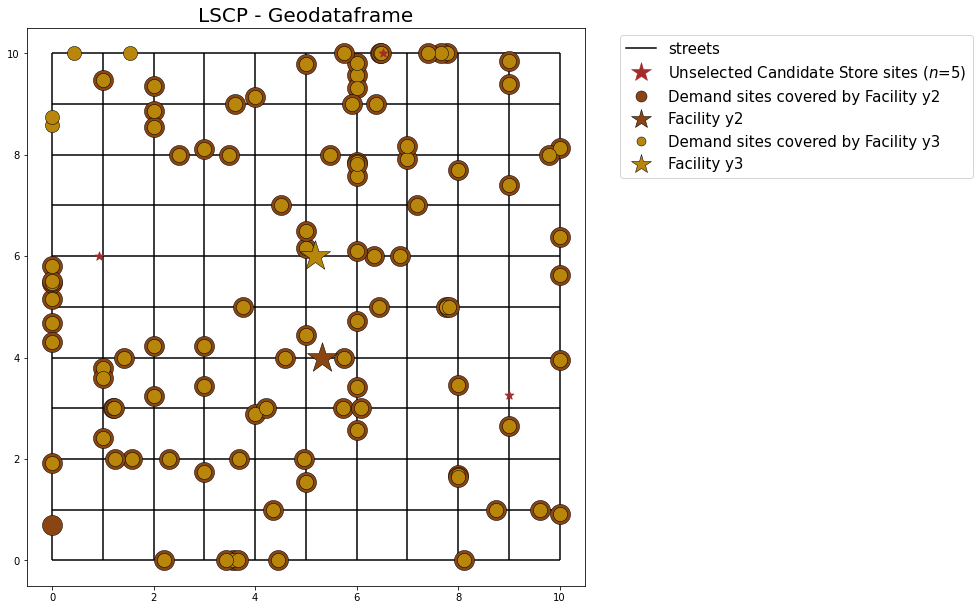

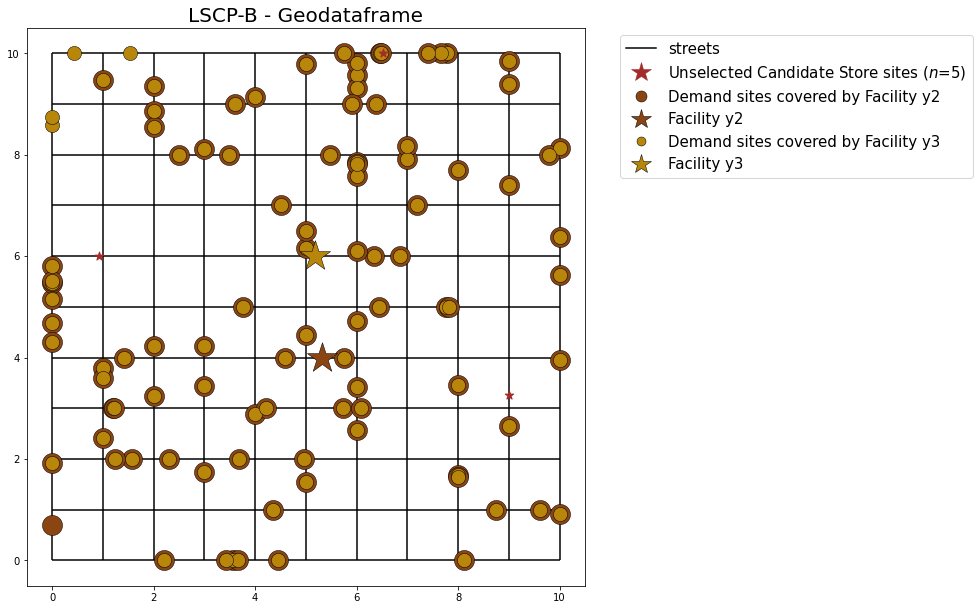

In [24]:
plot_results(lscp_from_geodataframe, facilities_snapped, clients_snapped, facilities_snapped.shape[0], "LSCP - Geodataframe", lscp_from_geodataframe.problem.objective.value())
plot_results(lscpb_from_geodataframe, facilities_snapped, clients_snapped, facilities_snapped.shape[0], "LSCP-B - Geodataframe", lscpb_from_geodataframe.lscp_obj_value)

The model results for the methods from_cost_matrix() and from_geodataframe() are distinctly different. This result is expected as the distance between facility and demand points is calculated using different metrics. The cost matrix is calculated with dijkstra distance while the distance using geodataframe is calculated with euclidean distance. 

Why do the results for from_geodataframe() require just one facility to cover all of the demand points? It can be explained by the nature of the problem. The problem was configured in a synthetic manner, the street is created with 10x10 lattice and the max_coverage parameter is 8 meters, so this result is expected. You can change the max_coverage parameter to 2 meters and you will obtain a different result, but be aware of how many points will be able to be covered.

### LSCP and LSCPB with preselected facilities

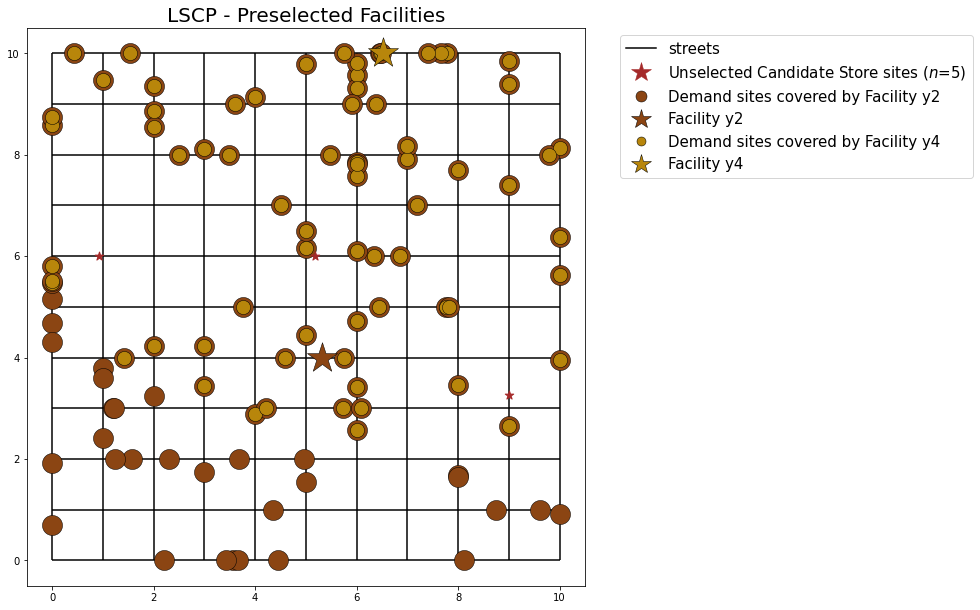

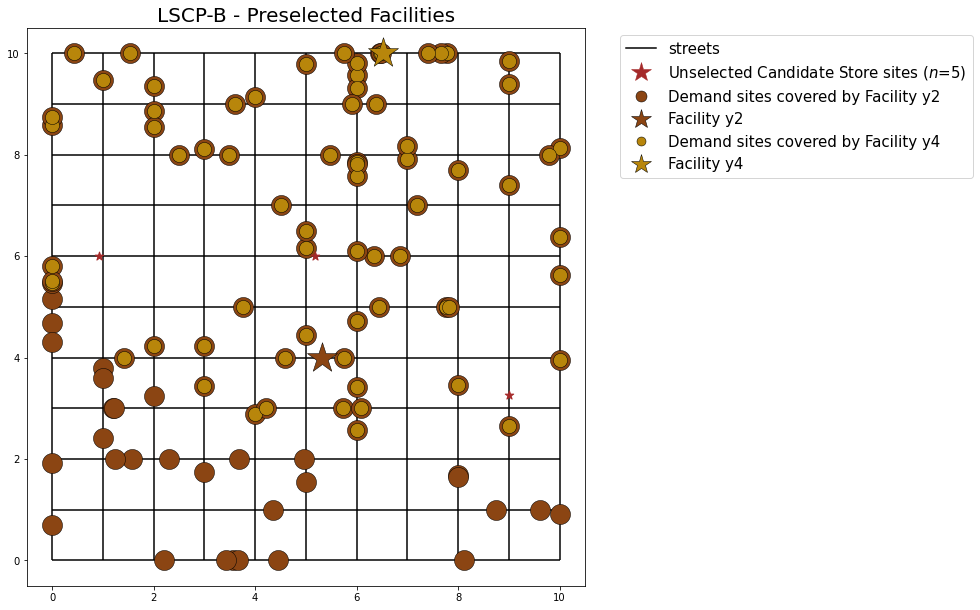

In [25]:
plot_results(lscp_preselected_from_geodataframe, facilities_snapped, clients_snapped, facilities_snapped.shape[0], "LSCP - Preselected Facilities", lscp_preselected_from_geodataframe.problem.objective.value())
plot_results(lscpb_preselected_from_geodataframe, facilities_snapped, clients_snapped, facilities_snapped.shape[0], "LSCP-B - Preselected Facilities", lscpb_preselected_from_geodataframe.lscp_obj_value)

## References

- [Church, R. L., & Murray, A. T. (2018). Location covering models: History, applications and advancements (1st edition 2018). Springer](https://www.springer.com/gb/book/9783319998459)
- [Toregas, C., Swain, R., ReVelle, C., &amp; Bergman, L. (1971). The location of emergency service facilities. Operations Research, 19(6), 1363–1373.](https://pubsonline.informs.org/doi/abs/10.1287/opre.19.6.1363)
- [Daskin MS, Stern EH (1981) A hierarchical objective set covering model for emergency medical
service vehicle deployment.](https://daskin.engin.umich.edu/wp-content/uploads/sites/133/2014/07/daskinandstern_ts1981_.pdf)